In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4658,11-12-2023,28.9495
4659,12-12-2023,28.9917
4660,13-12-2023,29.0295
4661,14-12-2023,29.0579


In [4]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [5]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


In [6]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [7]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


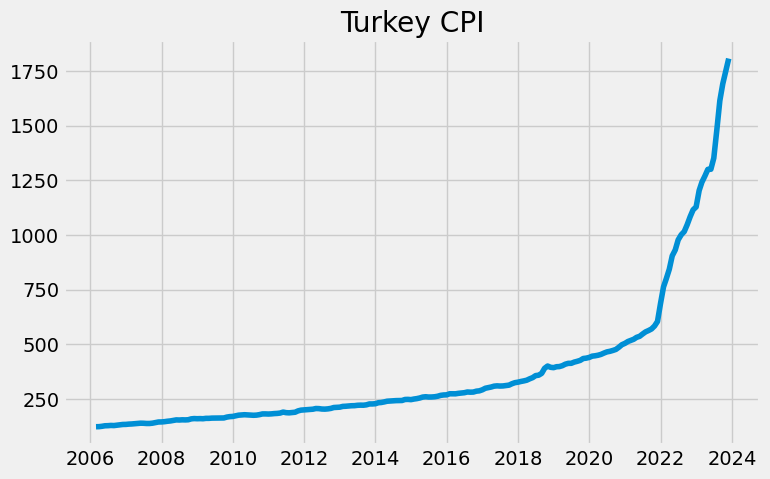

In [8]:
dates=pd.date_range('2006-02-01','2023-12-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [9]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [10]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2024-01-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637895
2023-11-30,130.503772


In [11]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933903
2023-11-30,134.158381


In [12]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-11-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.1
2023-09-30,9.0


In [13]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-08-31,85.104348
2023-09-30,92.766499
2023-10-31,88.704091


In [185]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10
213,2023-11,1.078661e+10


In [186]:
dates=pd.date_range('2006-02-01','2024-01-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503
213,2023-11,107.866144


In [187]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2024-01-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144


In [17]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
210,2023-8,23.50
211,2023-9,31.00
212,2023-10,33.00
213,2023-11,41.09


In [18]:
dates=pd.date_range('2006-02-28','2024-01-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00


In [19]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2024-01-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-08-31,45.7650
2023-09-30,56.3500
2023-10-31,59.3925
2023-11-30,58.6550


In [20]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-11-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-06-30,180.070938,186.192371,179.437348
2023-07-31,191.652101,194.142558,184.796934
2023-08-31,185.107822,183.341634,176.289202
2023-09-30,184.891859,183.368030,175.221191


In [21]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-12-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [22]:
sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-06-30,148.238298
2023-07-31,147.640395
2023-08-31,146.465496
2023-09-30,146.342705


In [23]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-08-31,29.4125
2023-09-30,41.6560
2023-10-31,43.8925
2023-11-30,45.6675


In [25]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2024-01-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49


In [26]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",end="2023-11-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09


In [27]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-12-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-07-31,81.62
2023-08-31,85.39
2023-09-30,89.35
2023-10-31,89.16


In [28]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-12-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-07-31,48.71
2023-08-31,52.42
2023-09-30,55.55
2023-10-31,56.01


In [29]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"][:-1].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["Borç"]=(borc["Borç"]/1e+08).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USD/TL,ParaArzi,Motorin,Perakende Satış,Sanayi,Kredi,M3,Borç,TÜFE
Tarih,,,,,,,,,
2010-02-28,0.574311,-0.468328,-0.470323,0.935668,2.358713,2.473323,-0.317515,1.774400,1.447693
2010-03-31,0.644001,1.850070,2.622296,1.971218,1.929881,2.894349,1.831928,1.064192,0.583272
2010-04-30,0.478728,1.038067,0.713406,0.918462,1.021775,3.033220,0.969354,0.366513,0.596780
2010-05-31,0.646630,0.240025,-0.856462,0.610769,2.763430,3.592510,0.095471,0.729264,-0.358182
2010-06-30,0.922501,1.537408,-0.175370,-0.094972,0.563442,3.358199,1.609402,-0.769974,-0.561672
...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.986884,-0.403339,5.675617,15.439600,9.689321,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.603827,-0.795784,1.850455,5.968276,2.618269,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.605829,-0.083836,2.080815,4.845313,4.384930,4.753114


In [30]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data=data.dropna(axis=0)
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,9.0220,91.32,95.75,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.6275,93.31,96.63,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.3125,93.75,97.25,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,11.0200,98.14,102.98,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.4940,99.40,105.10,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,7.066073,16.807611,-0.151044,38.5600,0.00,1.117934,7.55,-1.017069,2.406884,5.711697,39.5920,87.02,51.59,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.986884,45.8250,34.00,-0.403339,7.70,15.146856,9.689321,5.675617,33.1250,81.62,48.71,15.439600,9.3,17.50,9.488824
2023-08-31,10.505114,26.763908,-4.603827,45.7650,0.00,-0.795784,6.81,5.943431,2.618269,1.850455,29.4125,85.39,52.42,5.968276,9.1,23.50,9.086793


In [31]:
features=["USD/TL","Motorin","Enflasyon Belirsizliği","ParaArzi","Kredi Faizi","TÜFE"]
train=data[features].iloc[:-3,:]
test=data[features].iloc[-3:,:]


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [33]:
test_period = 3 
test_size = test_period   

train_data = data[:-test_size]
test_data = data[-test_size:]

# Bağımsız değişkenleri ve TÜFE'yi ayırın
X_train = train.drop(['TÜFE'], axis=1).values
y_train = train['TÜFE'].values
X_test = test.drop(['TÜFE'], axis=1).values
y_test = test['TÜFE'].values

In [34]:
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import keras
keras.utils.set_random_seed(1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(X_train_scaled.shape[1],1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(1))
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')


early_stopping = EarlyStopping(patience=25, restore_best_weights=True)

model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])


Epoch 1/500
4/4 [==============================] - 3s 135ms/step - loss: 4.6399 - val_loss: 0.9604
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 0.2269 - val_loss: 0.1399
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0184 - val_loss: 0.0669
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0125 - val_loss: 0.0637
Epoch 5/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0118 - val_loss: 0.0559
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0116 - val_loss: 0.0592
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0465
Epoch 8/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0195
Epoch 9/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0174 - val_loss: 0.0108
Epoch 10/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0723 - val_loss: 0.0172
Epoch 11/500
4/4 [

In [ ]:
'''import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ParameterGrid

# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)

# Model fonksiyonunu tanımlayın
def create_model(neurons=128, activation='relu', optimizer='adam', epochs=100):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])
    return model


# Grid Search için hiperparametre kombinasyonlarını tanımlayın
param_grid = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh','selu','sigmoid','elu','gelu','linear'],
    'optimizer': ['adam', 'rmsprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl'],
    'epochs': [500]
}

best_rmse = float('inf')
best_params = None

# Grid Search yapın
for params in ParameterGrid(param_grid):
    model = create_model(neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], epochs=params['epochs'])
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# En iyi hiperparametreleri ve sonuçları görüntüleyin
print("En iyi RMSE:", best_rmse)
print("En iyi parametreler:", best_params)'''


'import numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nfrom sklearn.metrics import make_scorer, mean_squared_error\nfrom sklearn.model_selection import ParameterGrid\n\n# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)\n\n# Model fonksiyonunu tanımlayın\ndef create_model(neurons=128, activation=\'relu\', optimizer=\'adam\', epochs=100):\n    model = Sequential()\n    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))\n    model.add(Dense(1))\n    model.compile(optimizer=optimizer, loss=\'mean_squared_error\')\n    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)\n    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])\n    return model\n\n\n# Grid Search için hiperparametre kombinasyonlarını tanımlayın\nparam_grid = {\n    \'neurons\'

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Modelinizi eğittikten sonra tahminlerinizi yapın
y_pred = model.predict(X_test_scaled)

# Tahminleri gerçek değerlerle karşılaştırarak MSE hesaplayın
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


1/1 [==============================] - 0s 286ms/step
Validation MSE: 0.0009687964120724201
Validation RMSE: 0.03112549456751523


In [36]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

# Tahmin edilen değerleri inceleyin
np.sqrt(mean_squared_error(y_test,y_pred_original_scale))

0.46745551050752115

In [ ]:
cor_matrix=data.corr()
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.721865
Motorin                   0.713822
ParaArzi                  0.677832
M3                        0.669235
Enflasyon Belirsizliği    0.624443
Kredi                     0.521249
Kredi Faizi               0.511942
Borç                      0.450264
Mevduat Faizi             0.434240
Zam                       0.407074
Politika Faizi            0.225434
Sanayi                   -0.049493
Perakende Satış          -0.113209
İşsizlik                 -0.194010
REDK                     -0.388566
REDKT                    -0.578101
Name: TÜFE, dtype: float64

In [ ]:
data.to_csv("data.csv")

In [ ]:
for combo in combinations(features, 5):
    selected_features = list(combo)
    selected_features.append('Zam')
    if (selected_features.count('Zam')==2):
            selected_features.remove('Zam')
    print(selected_features)

['USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'ParaArzi', 'Kredi Faizi', 'Zam']
['USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'ParaArzi', 'TÜFE', 'Zam']
['USD/TL', 'Motorin', 'Enflasyon Belirsizliği', 'Kredi Faizi', 'TÜFE', 'Zam']
['USD/TL', 'Motorin', 'ParaArzi', 'Kredi Faizi', 'TÜFE', 'Zam']
['USD/TL', 'Enflasyon Belirsizliği', 'ParaArzi', 'Kredi Faizi', 'TÜFE', 'Zam']
['Motorin', 'Enflasyon Belirsizliği', 'ParaArzi', 'Kredi Faizi', 'TÜFE', 'Zam']


In [ ]:
a=['USD/TL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi']
a.append('Zam')
print(a)

['USD/TL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Zam']


In [ ]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'REDK', 'REDKT', 'M3', 'İşsizlik', 'Politika Faizi']
train=data.iloc[:-3,:]
test=data.iloc[-3:,:]
X_train,X_test,y_train,y_test=train.iloc[:,:-1],test.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,-1]
best_mse=float("inf")
best_features=[]
for r in range(7,13):
   for combo in combinations(features, r):
        selected_features = list(combo)
        selected_features.append('Zam')
        if (selected_features.count('Zam')==2):
            selected_features.remove('Zam')
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train_subset, y_train) 
        y_pred=krr.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfeatures=[\'USD/TL\', \'Motorin\', \'Perakende Satış\', \'Zam\', \'Sanayi\',\n       \'Enflasyon Belirsizliği\', \'ParaArzi\', \'Borç\', \'Kredi\', \'Mevduat Faizi\',\n       \'REDK\', \'REDKT\', \'M3\', \'İşsizlik\', \'Politika Faizi\']\ntrain=data.iloc[:-3,:]\ntest=data.iloc[-3:,:]\nX_train,X_test,y_train,y_test=train.iloc[:,:-1],test.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,-1]\nbest_mse=float("inf")\nbest_features=[]\nfor r in range(7,13):\n   for combo in combinations(features, r):\n        selected_features = list(combo)\n        selected_features.append(\'Zam\')\n        if (selected_features.count(\'Zam\')==2):\n            selected_features.remove(\'Zam\')\n        X_train_subset = X_train[selected_features]\n        X_test_subset = X_test[selected_features]\n        krr = KernelRidge(alpha=1.0)\n

In [37]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi', 'Zam']
X = data[features]
X = sm.add_constant(X)
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model = sm.OLS(y, X).fit()
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [38]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik', 'Zam']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [39]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik', 'Zam']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [40]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik', 'Zam']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [41]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi', 'Zam']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [42]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi', 'Zam']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [43]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Sanayi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi', 'Zam']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [44]:
tahminler["LSTM"]=y_pred_original_scale
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred_original_scale)))

In [45]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Lars Regression,0.407510
Linear Regression,0.462003
LSTM,0.467456
Kernel Regression,0.553619
Gaussian Regression,0.661813
SGD Regressor,0.851212
Bayesian Regression,0.947320
Lasso Regression,1.027107


In [ ]:
tahminler.index.strftime("%Y-%m")

Index(['2023-08', '2023-09', '2023-10'], dtype='object', name='Tarih')

In [46]:
tahminler=tahminler.set_index(pd.date_range(start="2023-08",periods=3,freq="M"))
tahminler.index=tahminler.index.strftime("%Y-%m")


<Axes: >

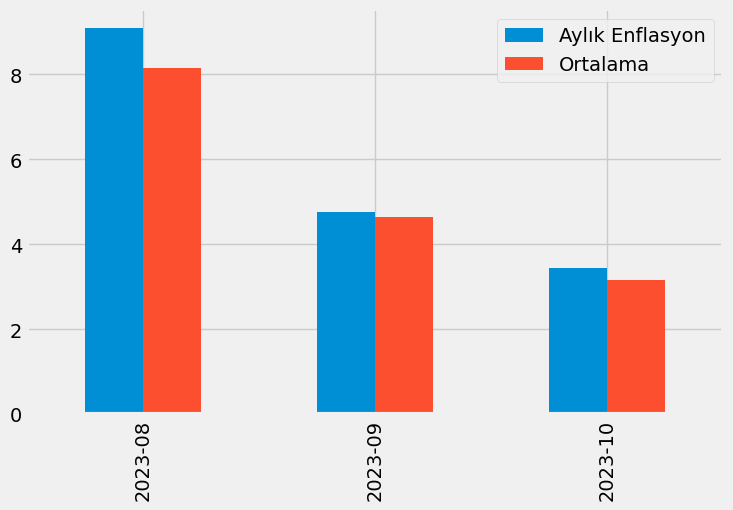

In [47]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Ortalama"]].plot(kind="bar",figsize=(8,5))

In [48]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(13)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-01-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40]
faiztahmin

,Politika Faizi
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,45.00
2024-02-29,45.00
2024-03-31,45.00
2024-04-30,45.00
2024-05-31,45.00


In [49]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-01-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,59.450000
2024-01-31,60.277463
2024-02-29,60.872919
2024-03-31,61.822326
2024-04-30,62.805473
2024-05-31,62.823337


In [50]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.7920
2010-02-28,13.5200
2010-03-31,13.5125
2010-04-30,13.0040
2010-05-31,13.1525
...,...
2023-06-30,38.5600
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500


In [51]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-10-31,59.392500
2023-11-30,58.655000
2023-12-31,59.450000
2024-01-31,60.277463
2024-02-29,60.872919
2024-03-31,61.822326
2024-04-30,62.805473
2024-05-31,62.823337
2024-06-30,64.189615
2024-07-31,64.584611


In [52]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz,trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(13,X=faiztahmin[5:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2023-11-30",periods=2,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2023-11-30,45.667500
2023-12-31,49.910000
2024-01-31,51.870055
2024-02-29,50.046293
2024-03-31,51.404267
2024-04-30,51.725178
2024-05-31,50.806896
2024-06-30,51.210384
2024-07-31,51.487292
2024-08-31,51.090609


In [53]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [54]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-08-31,2275.241982
2023-09-30,2504.165548
2023-10-31,2432.069312
2023-11-30,2316.594077


In [55]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,40
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [56]:
faiztahmin.columns=["Faiz"]


In [57]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [58]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [59]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [60]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(16,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-11-30,8.540840
2023-12-31,8.454193
2024-01-31,8.347127
2024-02-29,8.364339
2024-03-31,8.439923
2024-04-30,8.466738
2024-05-31,8.534691
2024-06-30,8.602699
2024-07-31,8.653981
2024-08-31,8.715422


In [61]:
from prophet import Prophet


In [62]:
df6.shape

(215, 1)

In [63]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,500)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=14,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-14])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,500)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6.index\n    sn["y"]=df6.values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=params

In [64]:
'''study.best_params'''

'study.best_params'

In [65]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
sn["cap"]=285.7233032513667
prophet=Prophet(growth="linear",changepoint_prior_scale=4.913477926048151,changepoint_range=0.8995647346860385,seasonality_prior_scale=5.929453787047488,n_changepoints=24,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=285.7233032513667
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing


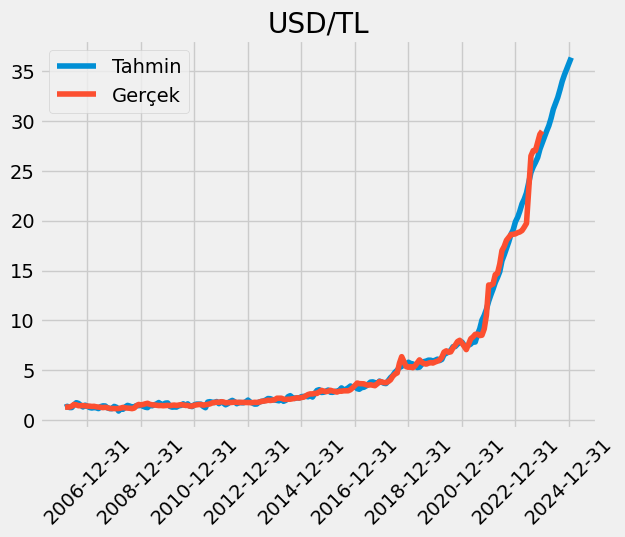

In [66]:
plt.title("USD/TL")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df6["USD/TL"],label="Gerçek")
plt.xticks(predictions.index[10::24],rotation=45)
plt.legend()
plt.show()

In [67]:
usdtahmin=(predictions["yhat"][-14:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-01-31    2.243153
2024-02-29    2.014900
2024-03-31    1.924195
2024-04-30    2.462766
2024-05-31    3.018529
2024-06-30    1.904892
2024-07-31    1.899384
2024-08-31    2.451837
2024-09-30    2.494163
2024-10-31    1.942112
2024-11-30    1.629988
2024-12-31    1.665538
2025-01-31    1.572790
Name: yhat, dtype: float64

In [68]:
df6.iloc[-1,0]=df6.iloc[-1,0]+0.03

In [69]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-5:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", end="2025-02-27", freq="1M"))
usdtahmin1

,USD/TL
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,28.986800
2024-01-31,29.637018
2024-02-29,30.234175
2024-03-31,30.815939
2024-04-30,31.574864
2024-05-31,32.527960


In [70]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'm':trial.suggest_int('m',0,180),
                'cap':trial.suggest_int('cap',1,1000)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[params["m"]:-12].index
    sn["y"]=df14[params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df14["Brent"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'m\':trial.suggest_int(\'m\',0,180),\n                \'cap\':trial.suggest_int(\'cap\',1,1000)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[params["m"]:-12].index\n    sn["y"]=df14[params["m"]:-12].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=12,freq="M")\n    future_dates["cap"]=params["cap"]\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(

In [71]:
#study.best_params

In [72]:
sn=pd.DataFrame()
sn["ds"]=df14[51:].index
sn["y"]=df14[51:].values
sn["cap"]=741
prophet=Prophet(growth="logistic",changepoint_prior_scale=9.40940230511886,changepoint_range=0.26678385022653445)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=741
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:19:04 - cmdstanpy - INFO - Chain [1] start processing


12:19:04 - cmdstanpy - INFO - Chain [1] done processing


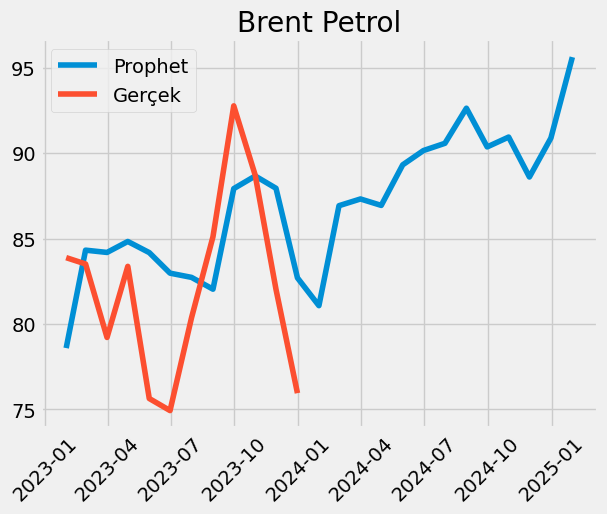

In [73]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [395]:
'''from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping

train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme
layer_units = [64, 128]  # LSTM katmanındaki nöron sayısı
dense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı
activations = ['relu', 'tanh','sigmoid','elu','selu']  # Aktivasyon fonksiyonları
learning_rates = [0.001, 0.01]  # Öğrenme hızı
optimizers = ['adam', 'sgd']  # Optimizer'lar

best_mse = float('inf')
best_model = None

for lstm_units in layer_units:
    for dense_unit in dense_units:
        for activation in activations:
            for learning_rate in learning_rates:
                for optimizer_name in optimizers:
                    try:
                        # Modeli oluşturma
                        model = Sequential()
                        model.add(LSTM(units=lstm_units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
                        model.add(Dense(units=dense_unit, activation=activation))
                        model.add(Dense(units=1))
                        
                        # Optimizer'ı ve learning rate'i ayarlama
                        if optimizer_name == 'adam':
                            optimizer = Adam(learning_rate=learning_rate)
                        elif optimizer_name == 'sgd':
                            optimizer = SGD(learning_rate=learning_rate)  # SGD için gerekirse import etmeyi unutmayın
                        
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        
                        # Modeli eğitme ve early stopping uygulama
                        model.fit(X_train, y_train, epochs=250, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)
                        
                        # Modeli değerlendirme
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))
                        
                        # En iyi modeli güncelleme
                        if mse < best_mse:
                            best_mse = mse
                            best_model = model
                    except Exception as e:
                        print(f'Hata oluştu: {e}')

# En iyi modelin MSE değerini ve kullanılan optimizer'ı yazdırma
print(f'En İyi Modelin Ortalama Kare Hatası (MSE): {best_mse}')
if best_model is not None:
    print(f'En İyi Modelde Kullanılan Optimizer: {best_model.optimizer.get_config()["name"]}')
'''

'from sklearn.model_selection import train_test_split\nfrom tensorflow.keras.optimizers import Adam,SGD\nfrom tensorflow.keras.callbacks import EarlyStopping\n\ntrain_size=-12\n# Veriyi eğitim ve test setlerine bölme\n\nX_train, X_test = X[:train_size], X[train_size:]\ny_train, y_test = y[:train_size], y[train_size:]\n\n# Early stopping\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=10, restore_best_weights=True)\n\n# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme\nlayer_units = [64, 128]  # LSTM katmanındaki nöron sayısı\ndense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı\nactivations = [\'relu\', \'tanh\',\'sigmoid\',\'elu\',\'selu\']  # Aktivasyon fonksiyonları\nlearning_rates = [0.001, 0.01]  # Öğrenme hızı\noptimizers = [\'adam\', \'sgd\']  # Optimizer\'lar\n\nbest_mse = float(\'inf\')\nbest_model = None\n\nfor lstm_units in layer_units:\n    for dense_unit in dense_units:\n        for activation in activations:\n  

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df14)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
keras.utils.set_random_seed(7)
model = Sequential()
model.add(LSTM(units=128, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=16, activation='sigmoid'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
10/10 [==============================] - 3s 51ms/step - loss: 0.1923 - val_loss: 0.1956
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0810 - val_loss: 0.0168
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0699 - val_loss: 0.0626
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0614 - val_loss: 0.0281
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0566 - val_loss: 0.0394
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0539 - val_loss: 0.0309
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0538 - val_loss: 0.0345
Epoch 8/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0542 - val_loss: 0.0533
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0490 - val_loss: 0.0171
Epoch 10/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0466 - val_loss: 0.0493

1/1 [==============================] - 0s 228ms/step


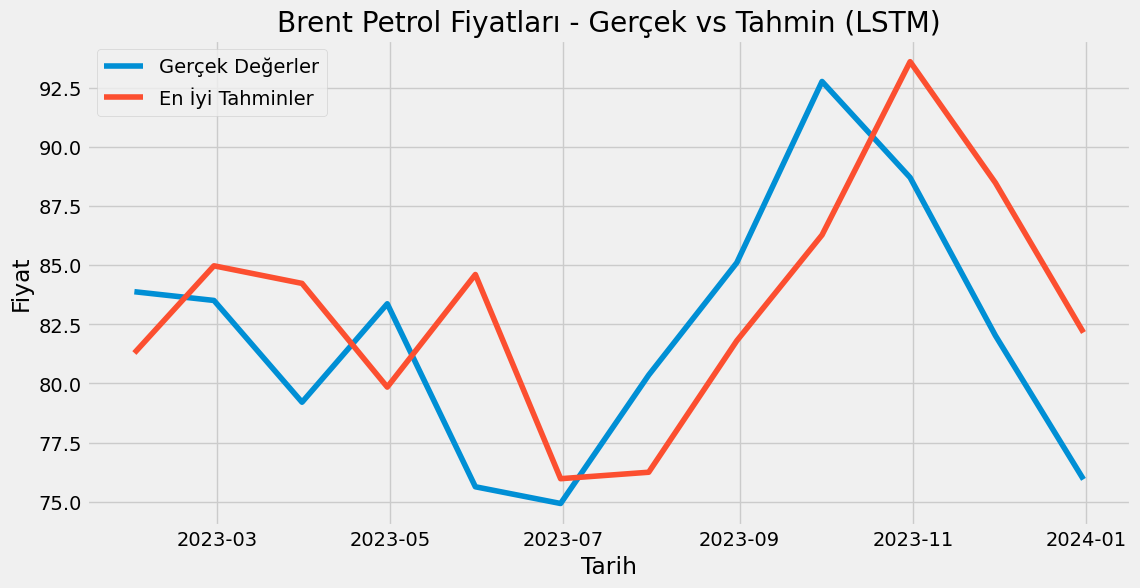

In [76]:
pred=scaler.inverse_transform(model.predict(X_test))
plt.figure(figsize=(12, 6))
plt.plot(df14.index[-len(y_test):], scaler.inverse_transform(y_test), label='Gerçek Değerler')
plt.plot(df14.index[-len(y_test):], pred, label='En İyi Tahminler')
plt.title('Brent Petrol Fiyatları - Gerçek vs Tahmin (LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

In [77]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df14)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [78]:
# generate the input and output sequences
n_lookback = 13  # length of input sequences (lookback period)
n_forecast = 13  # length of output sequences (forecast period)
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
keras.utils.set_random_seed(0)
# fit the model
model = Sequential()
model.add(LSTM(units=128, activation='sigmoid', return_sequences=True, input_shape=(n_lookback, 1)))
model.add(Dense(units=16, activation='sigmoid'))  # Dense katmanı eklendi
model.add(Dense(units=1))  # Çıkış birimi sayısını 1 olarak değiştirildi

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=16, verbose=1)

# generate the forecasts
X_ = y[-n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

# Tahmin yaparken çıkış şeklini düzenle
Y_ = model.predict(X_).reshape(1, n_forecast)

# Orijinal ölçekleme işlemi
Y_ = scaler.inverse_transform(Y_)

print(Y_)



Epoch 1/100
11/11 [==============================] - 3s 12ms/step - loss: 0.4252
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1113
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0813
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0702
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0668
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0641
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0624
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0608
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0607
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0589
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0577
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0576
Epoch 13/100
11/11 [======

In [79]:
Y_=np.array(Y_).reshape(-1,1)

In [80]:
future=pd.DataFrame()
future["Brent"]=df14["Brent"]
Y_=pd.DataFrame(Y_)
Y_.columns=["Brent"]
Y_=Y_.set_index(pd.date_range(start="2024-01-31",periods=13,freq="M"))
future=pd.concat([future,Y_],axis=0)
future

,Brent
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-09-30,76.827606
2024-10-31,79.160439
2024-11-30,78.449165
2024-12-31,76.489174


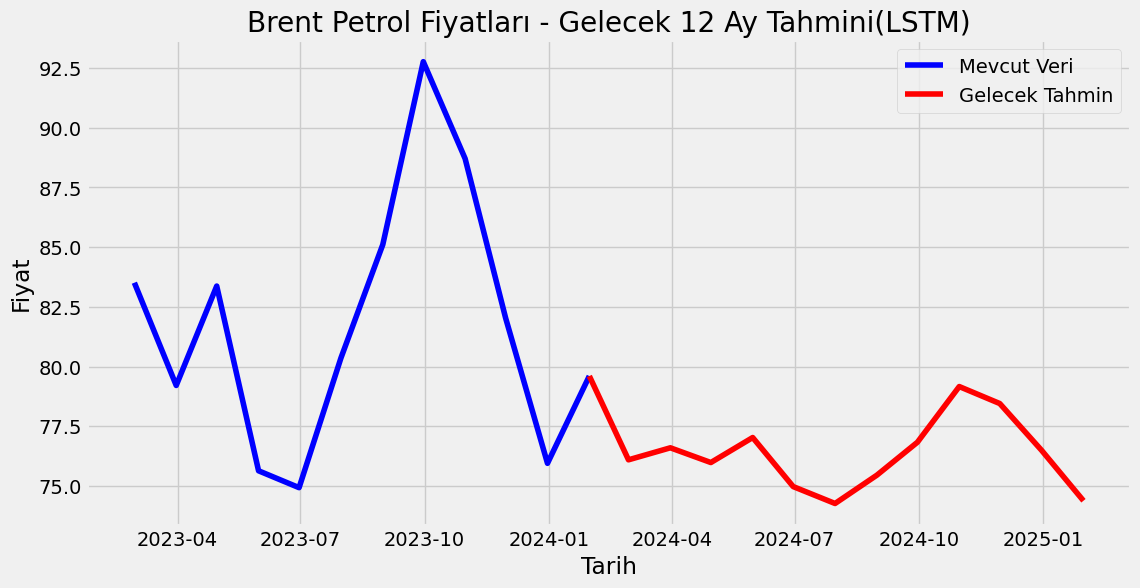

In [81]:
plt.figure(figsize=(12, 6))
#plt.plot(pred,label='Test Tahmini',color='green')
plt.plot(future["Brent"][-24:-12], label='Mevcut Veri',color='blue')
plt.plot(future["Brent"][-13:] ,label='Gelecek Tahmin',color='red')
plt.title('Brent Petrol Fiyatları - Gelecek 12 Ay Tahmini(LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


In [82]:
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49


In [83]:
enf_belirsizlik["Enflasyon Belirsizliği"][-12:]

2023-01-31    9.44
2023-02-28    7.31
2023-03-31    7.59
2023-04-30    7.51
2023-05-31    7.37
2023-06-30    7.55
2023-07-31    7.70
2023-08-31    6.81
2023-09-30    7.30
2023-10-31    5.57
2023-11-30    4.49
2023-12-31    3.36
Freq: M, Name: Enflasyon Belirsizliği, dtype: float64

In [394]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.0001,0.9999),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400),
                'm':trial.suggest_int('m',0,105)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik[params["m"]:].index
    sn["y"]=enf_belirsizlik[params["m"]:].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.0001,0.9999),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400),\n                \'m\':trial.suggest_int(\'m\',0,105)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik[params["m"]:].index\n    sn["y"]=en

In [154]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik[55:].index
sn["y"]=enf_belirsizlik[55:].values
sn["cap"]=0
prophet=Prophet(changepoint_prior_scale=3.646029869236057,changepoint_range=0.9986477932636241,growth='linear',n_changepoints=45,seasonality_prior_scale=9.989607383352132,yearly_seasonality=True,weekly_seasonality=False)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=0
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

13:56:07 - cmdstanpy - INFO - Chain [1] start processing
13:56:10 - cmdstanpy - INFO - Chain [1] done processing


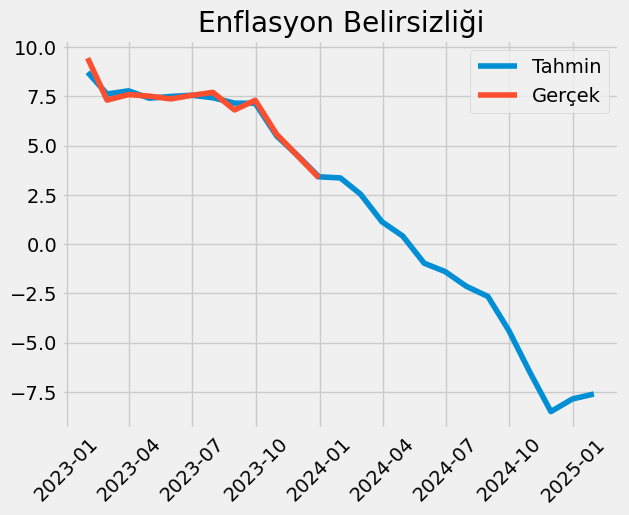

In [155]:
plt.title("Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.plot(enf_belirsizlik["Enflasyon Belirsizliği"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [165]:
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49


In [166]:
model=auto_arima(enf_belirsizlik,trace=False,information_criterion='aic',seasonal=True,m=5)
enfbelirsizliktahmin1=model.predict(13)
enfbelirsizliktahmin1=pd.DataFrame(enfbelirsizliktahmin1)
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-1:,0]},index=pd.date_range(start="2023-12-30",periods=1,freq="1M"))
enfbelirsizliktahmin1=pd.concat([row,enfbelirsizliktahmin1],axis=0)
enfbelirsizliktahmin1


,Enflasyon Belirsizliği
2023-12-31,3.360000
2024-01-31,2.395268
2024-02-29,2.705154
2024-03-31,2.729013
2024-04-30,2.666159
2024-05-31,1.887541
2024-06-30,1.270527
2024-07-31,1.320320
2024-08-31,1.879789
2024-09-30,2.188238


In [90]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [91]:
#study.best_params

In [92]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].values
sn["cap"]=190
prophet=Prophet(changepoint_prior_scale=3.481321992729419,changepoint_range=0.8995930316928846,growth='linear',seasonality_prior_scale=8.977376335194005,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=16,freq="M")
future_dates["cap"]=190
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:19:33 - cmdstanpy - INFO - Chain [1] start processing


12:19:33 - cmdstanpy - INFO - Chain [1] done processing


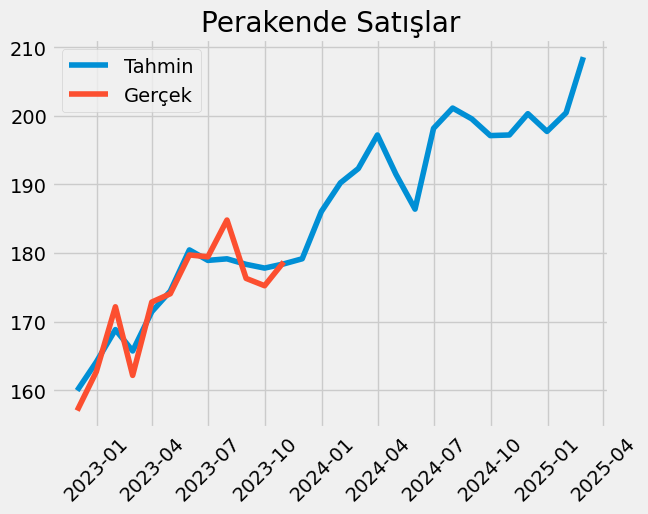

In [93]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-28:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [94]:
perakendetahmin=(predictions["yhat"][-29:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2022-11-30    3.216423
2022-12-31    2.596770
2023-01-31    2.882036
2023-02-28   -1.843518
2023-03-31    3.450989
2023-04-30    1.752146
2023-05-31    3.443678
2023-06-30   -0.845366
2023-07-31    0.126571
2023-08-31   -0.448943
2023-09-30   -0.306626
2023-10-31    0.344698
2023-11-30    0.417766
2023-12-31    3.837414
2024-01-31    2.255112
2024-02-29    1.093496
2024-03-31    2.545369
2024-04-30   -2.901185
2024-05-31   -2.657283
2024-06-30    6.315988
2024-07-31    1.493700
2024-08-31   -0.782232
2024-09-30   -1.221874
2024-10-31    0.044657
2024-11-30    1.575699
2024-12-31   -1.293369
2025-01-31    1.373530
2025-02-28    4.050079
Name: yhat, dtype: float64

In [95]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((future[-16:].pct_change(periods=1)*100).dropna())/100)).values)
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-11-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-6.284243
2024-01-31,7.165296
2024-02-29,-2.482891
2024-03-31,2.598516
2024-04-30,1.637228
2024-05-31,4.438467
2024-06-30,-0.813716
2024-07-31,0.937399
2024-08-31,4.089787


In [96]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"][params["m"]:-12].index
    sn["y"]=money["Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"][params["m"]:-12].index\n    sn["y"]=money["Para Arzi"][

In [97]:
#study.best_params

In [98]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"][110:].index
sn["y"]=money["Para Arzi"][110:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=0.17670782903839727,changepoint_range=0.8995442051379563,growth='linear',seasonality_prior_scale=9.026889153868014)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:19:34 - cmdstanpy - INFO - Chain [1] start processing
12:19:34 - cmdstanpy - INFO - Chain [1] done processing


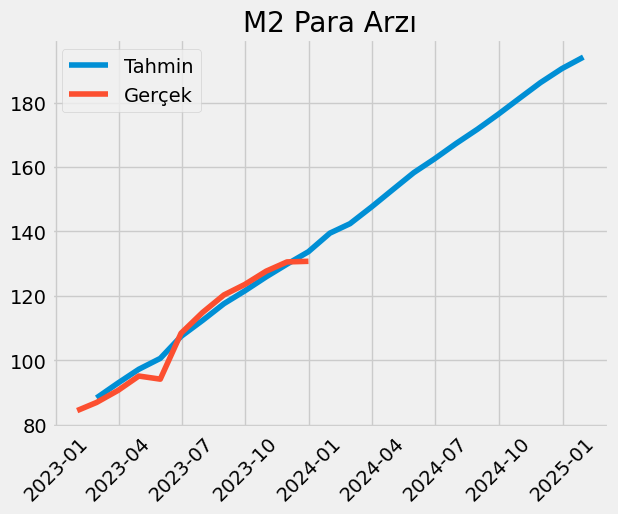

In [99]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"][-24:],label="Tahmin")
plt.plot(money["Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [100]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(14)
paraarzitahmin

ds
2023-12-31    2.986980
2024-01-31    4.309140
2024-02-29    2.105570
2024-03-31    3.636017
2024-04-30    3.566743
2024-05-31    3.531939
2024-06-30    2.711238
2024-07-31    2.923175
2024-08-31    2.663205
2024-09-30    2.699266
2024-10-31    2.846046
2024-11-30    2.656141
2024-12-31    2.340900
2025-01-31    1.875799
Name: yhat, dtype: float64

In [101]:
paraarzitahmin1 = []
result = money.iloc[-2,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-4:-1,0]},index=pd.date_range(start="2023-09-30",periods=3,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,Para Arzi
2023-09-30,123.493114
2023-10-31,127.637895
2023-11-30,130.503772
2023-12-31,134.401893
2024-01-31,140.193459
2024-02-29,143.145330
2024-03-31,148.350119
2024-04-30,153.641387
2024-05-31,159.067908
2024-06-30,163.380618


In [102]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [103]:
#study.best_params

In [104]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=3.671534257218686,changepoint_range=0.8995013103592469,growth='linear',seasonality_prior_scale=4.464356522636207,n_changepoints=2)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=15,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:19:34 - cmdstanpy - INFO - Chain [1] start processing


12:19:35 - cmdstanpy - INFO - Chain [1] done processing


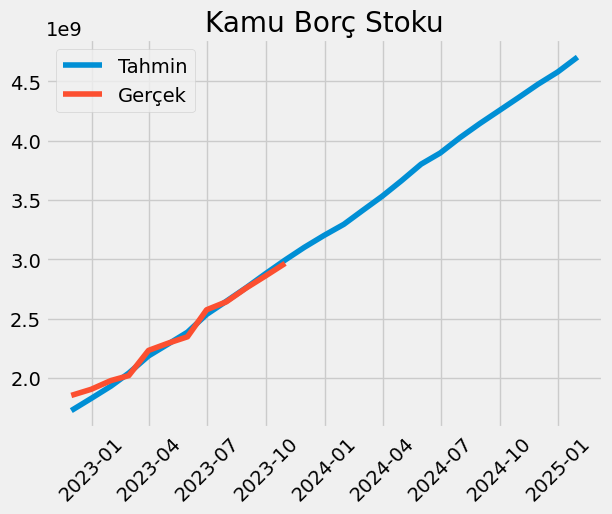

In [105]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [106]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(15)
borctahmin

ds
2023-11-30    3.559255
2023-12-31    3.244173
2024-01-31    2.926886
2024-02-29    3.485270
2024-03-31    3.559589
2024-04-30    3.668327
2024-05-31    3.845606
2024-06-30    2.474374
2024-07-31    3.328458
2024-08-31    2.939537
2024-09-30    2.606123
2024-10-31    2.633038
2024-11-30    2.534552
2024-12-31    2.318555
2025-01-31    2.736112
Name: yhat, dtype: float64

In [107]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-07-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.072357e+09
2023-12-31,3.172030e+09
2024-01-31,3.264872e+09
2024-02-29,3.378661e+09
2024-03-31,3.498928e+09
2024-04-30,3.627280e+09


In [108]:
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144


In [109]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"][params["m"]:-12].index
    sn["y"]=df3["Kredi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3["Kredi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"][params["m"]:-12].index\n    sn["y"]=df3["Kredi"][params["m"]:

In [110]:
#study.best_params

In [188]:
df3=df3.iloc[:-1]
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503


In [189]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"][150:].index
sn["y"]=df3["Kredi"][150:].values
sn["cap"]=381.79609705677035
prophet=Prophet(changepoint_prior_scale=2.10520609698171,changepoint_range=0.6734967268169046,growth='logistic',seasonality_prior_scale=4.921223978299016,n_changepoints=6,yearly_seasonality=True,weekly_seasonality='auto')

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
future_dates["cap"]=381.79609705677035
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:24 - cmdstanpy - INFO - Chain [1] done processing


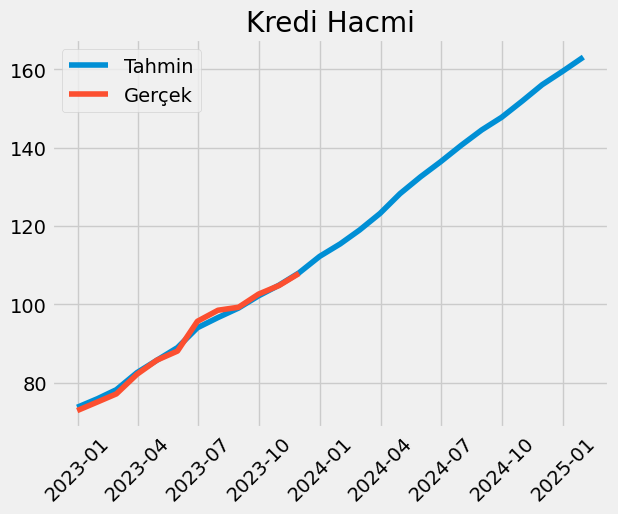

In [190]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(df3["Kredi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [192]:
kreditahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(16)
kreditahmin

ds
2023-10-31    2.689119
2023-11-30    2.998547
2023-12-31    3.879324
2024-01-31    2.848532
2024-02-29    3.045645
2024-03-31    3.589800
2024-04-30    4.087201
2024-05-31    3.364752
2024-06-30    2.879236
2024-07-31    3.078845
2024-08-31    2.801191
2024-09-30    2.236073
2024-10-31    2.806838
2024-11-30    2.746276
2024-12-31    2.211672
2025-01-31    2.254264
Name: yhat, dtype: float64

In [195]:
kreditahmin1 = []
result = df3.iloc[-3,0]
for i in range(len(kreditahmin)):
    result *= (1 + kreditahmin[i] / 100)
    kreditahmin1.append(result)

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2023-10-30", end="2025-02-27", freq="1M"))
kreditahmin1.iloc[:2,0]=df3.iloc[-2:,0]
kreditahmin1

,Kredi
2023-10-31,104.793503
2023-11-30,107.866144
2023-12-31,112.709230
2024-01-31,115.919789
2024-02-29,119.450293
2024-03-31,123.738320
2024-04-30,128.795754
2024-05-31,133.129412
2024-06-30,136.962522
2024-07-31,141.179385


In [115]:
m3=m3.iloc[:-1]
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933903


In [116]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index
    sn["y"]=m3["M3 Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3 Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index\n    sn["y"]=m3["M3 Para Arzi"][

In [117]:
#study.best_params

In [118]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"][151:].index
sn["y"]=m3["M3 Para Arzi"][151:].values
sn["cap"]=386.728728252815
prophet=Prophet(changepoint_prior_scale=1.0239522189165728,changepoint_range=0.8631788185438879,growth='logistic',seasonality_prior_scale=8.271825948806738,n_changepoints=14,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
future_dates["cap"]=386.728728252815
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:19:36 - cmdstanpy - INFO - Chain [1] start processing


12:19:39 - cmdstanpy - INFO - Chain [1] done processing


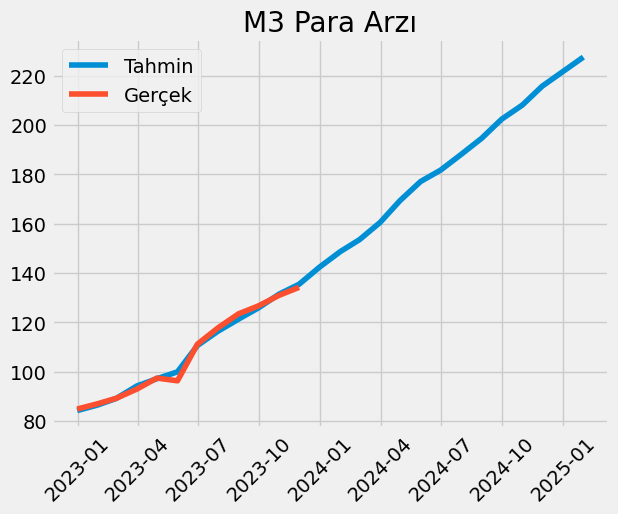

In [119]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(m3["M3 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [120]:
m3tahmin=predictions["yhat"].tail(17)
m3tahmin[:3]=m3.iloc[-3:,0]
m3tahmin=pd.DataFrame(m3tahmin)
m3tahmin.columns=["M3"]
m3tahmin=m3tahmin.set_index(pd.date_range(start="2023-09-30",periods=len(m3tahmin),freq="1M"))
m3tahmin

,M3
2023-09-30,126.660411
2023-10-31,130.933903
2023-11-30,134.158381
2023-12-31,142.401599
2024-01-31,148.651379
2024-02-29,153.509455
2024-03-31,160.494148
2024-04-30,169.358523
2024-05-31,177.113610
2024-06-30,181.710447


In [122]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [393]:
#study.best_params

In [168]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=9.619978429571834,changepoint_range=0.8872026398316396,growth='linear',seasonality_prior_scale=4.66384076344283,n_changepoints=25,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=15,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

14:06:09 - cmdstanpy - INFO - Chain [1] start processing
14:06:09 - cmdstanpy - INFO - Chain [1] done processing


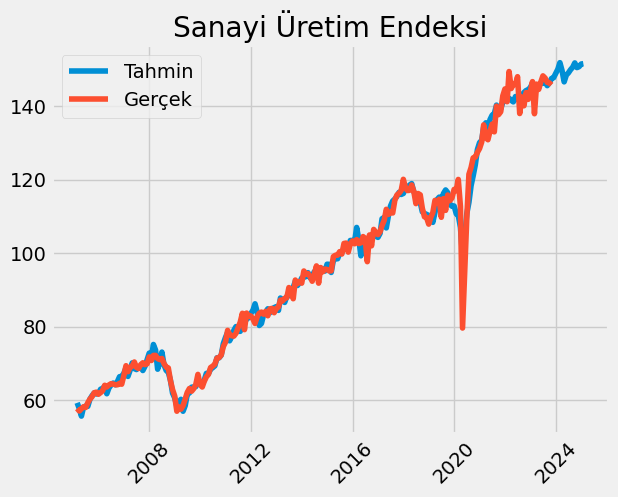

In [169]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [170]:
sanayitahmin=(predictions["yhat"].tail(16).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-02-27", freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

,Sanayi
2023-11-30,108.813958
2023-12-31,109.667217
2024-01-31,110.534526
2024-02-29,111.831081
2024-03-31,110.226636
2024-04-30,107.984909
2024-05-31,109.345026
2024-06-30,109.784837
2024-07-31,110.417201
2024-08-31,110.921086


In [ ]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"][params["m"]:-36].index
    sn["y"]=redkt["REDKT"][params["m"]:-36].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"][-36:],predictions["yhat"][-36:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"][params["m"]:-36].index\n    sn["y"]=redkt["REDKT"][params[

In [ ]:
#study.best_params

In [171]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=300
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
future_dates["cap"]=300
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

14:06:15 - cmdstanpy - INFO - Chain [1] start processing
14:06:15 - cmdstanpy - INFO - Chain [1] done processing


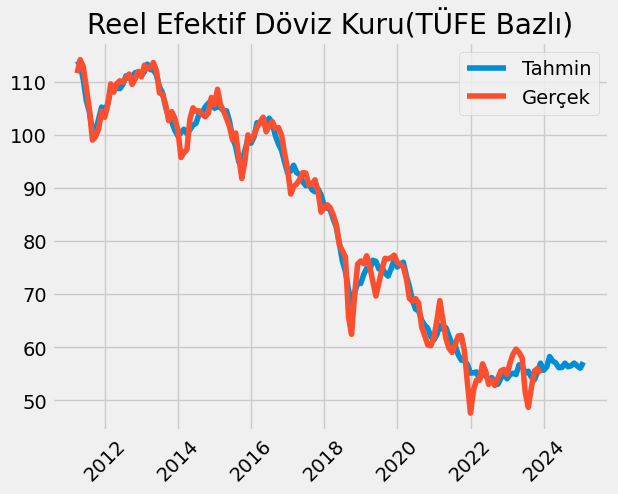

In [172]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
predictions["yhat"].tail(15)

ds
2023-11-30    57.016442
2023-12-31    55.680358
2024-01-31    56.309661
2024-02-29    58.274112
2024-03-31    57.428478
2024-04-30    57.089969
2024-05-31    56.172834
2024-06-30    56.211509
2024-07-31    57.022767
2024-08-31    56.360198
2024-09-30    56.528234
2024-10-31    57.037651
2024-11-30    56.514103
2024-12-31    56.071645
2025-01-31    57.206708
Name: yhat, dtype: float64

In [173]:
redkttahmin=predictions["yhat"].tail(27)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin

,REDKT
2023-12-31,55.124752
2024-01-31,54.100201
2024-02-29,54.903269
2024-03-31,55.120650
2024-04-30,54.896201
2024-05-31,56.713874
2024-06-30,56.546257
2024-07-31,55.152070
2024-08-31,55.504813
2024-09-30,54.386131


In [ ]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic','linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\',\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [ ]:
#study.best_params

In [174]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
sn["cap"]=165
prophet=Prophet(changepoint_prior_scale=4.697452368413781,
 changepoint_range=0.9845493532029166,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=165
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

14:06:21 - cmdstanpy - INFO - Chain [1] start processing
14:06:22 - cmdstanpy - INFO - Chain [1] done processing


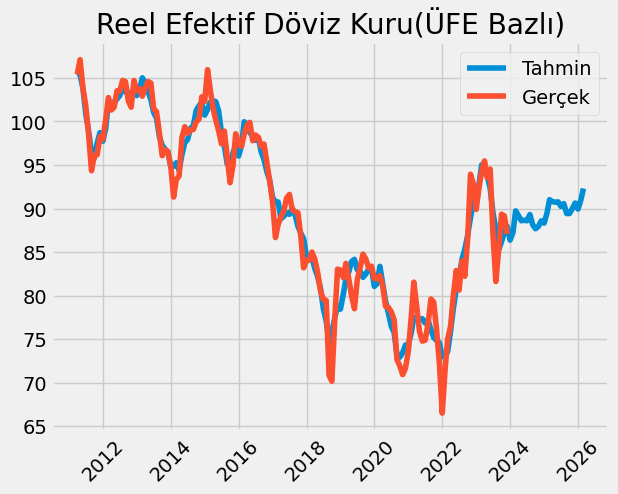

In [175]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [176]:
redktahmin=predictions["yhat"].tail(27)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redktahmin

,REDK
2023-12-31,86.373456
2024-01-31,87.239667
2024-02-29,89.729383
2024-03-31,89.170241
2024-04-30,88.597250
2024-05-31,88.653628
2024-06-30,88.593602
2024-07-31,89.307854
2024-08-31,88.121405
2024-09-30,87.675159


In [197]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),paraarzitahmin1["Para Arzi"].shift(1),sanayitahmin1["Sanayi"],kreditahmin1.rolling(2).mean(),m3tahmin.shift(1),borctahmin1.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende"]=perakendetahmin



tahmindf=tahmindf.iloc[:19]
tahmindf["Politika Faizi"]=[40,40,40,40,40,42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40]
tahmindf=tahmindf[['USD/TL', 'Motorin','Perakende', 'Kredi Faizi', 'Zam','Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','M3','REDKT','REDK','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Perakende Satış","Kredi Faizi","Zam","Sanayi","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','M3','REDKT','REDK','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)





tahmindf.iloc[0,1]=-4.67
#tahmindf.iloc[0,0]=2.42
tahmindf

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,M3,REDKT,REDK,İşsizlik,Politika Faizi
2023-12-31,2.392823,-4.670000,3.837414,59.450000,0.0,0.784145,3.360000,2.245318,3.559255,3.722251,49.910000,2.462676,55.124752,86.373456,8.454193,42.5
2024-01-31,2.095361,7.165296,2.255112,60.277463,40.0,0.790856,2.395268,2.986980,3.244173,3.651198,51.870055,6.144393,54.100201,87.239667,8.347127,45.0
2024-02-29,1.830250,-2.482891,1.093496,60.872919,0.0,1.172986,2.705154,4.309140,2.926886,2.948472,50.046293,4.388841,54.903269,89.729383,8.364339,45.0
2024-03-31,2.058497,2.598516,2.545369,61.822326,0.0,-1.434704,2.729013,2.105570,3.485270,3.321803,51.404267,3.268100,55.120650,89.170241,8.439923,45.0
2024-04-30,2.136847,1.637228,-2.901185,62.805473,0.0,-2.033743,2.666159,3.636017,3.559589,3.842886,51.725178,4.550008,54.896201,88.597250,8.466738,45.0
2024-05-31,2.476422,4.438467,-2.657283,62.823337,0.0,1.259544,1.887541,3.566743,3.668327,3.718742,50.806896,5.523177,56.713874,88.653628,8.534691,45.0
2024-06-30,2.456462,-0.813716,6.315988,64.189615,0.0,0.402223,1.270527,3.531939,3.845606,3.117977,51.210384,4.579094,56.546257,88.593602,8.602699,45.0
2024-07-31,2.264586,0.937399,1.493700,64.584611,0.0,0.576003,1.320320,2.711238,2.474374,2.980457,51.487292,2.595418,55.152070,89.307854,8.653981,45.0
2024-08-31,2.088815,4.089787,-0.782232,64.493004,0.0,0.456347,1.879789,2.923175,3.328458,2.937913,51.090609,3.513912,55.504813,88.121405,8.715422,45.0
2024-09-30,2.285898,4.365349,-1.221874,64.596012,0.0,0.778023,2.188238,2.663205,2.939537,2.514729,51.179896,3.496113,54.386131,87.675159,8.774888,45.0


In [ ]:
df6.to_csv('df6.csv')

In [201]:
import keras
import keras.optimizers
keras.utils.set_random_seed(7)
X = data.drop(['TÜFE'], axis=1).values
y = data['TÜFE'].values
X=data[['USD/TL',
 'Motorin',
 'Enflasyon Belirsizliği',
 'ParaArzi','Zam','Kredi','REDKT']].values

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(7,1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(1))
rms = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')




model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)

Epoch 1/100


4/4 [==============================] - 2s 11ms/step - loss: 6.2559
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7813
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0470
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0263
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0224
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0209
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0184
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0162
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 10/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 12/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0157
Epoch 13/100
4/4 [==============================] - 0s 8ms/step - loss

In [202]:
tahmin=tahmindf[['USD/TL',
 'Motorin',
 'Enflasyon Belirsizliği',
 'ParaArzi','Kredi','Zam','REDKT']].values

X_scaled = scaler.fit_transform(X)
tahmin_scaled = scaler.transform(tahmin)

In [203]:
pred = model.predict(tahmin_scaled)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))
pred = scaler.inverse_transform(pred)
pred

1/1 [==============================] - 0s 248ms/step


array([[2.7351263],
       [3.6235423],
       [2.8085854],
       [2.8497837],
       [2.9390955],
       [2.8461392],
       [2.580946 ],
       [2.640271 ],
       [2.8035824],
       [2.898057 ],
       [2.9044082],
       [2.6318338],
       [2.5055273],
       [2.9137738]], dtype=float32)

In [204]:
corr=data.corr()["TÜFE"].sort_values(ascending=False)
np.abs(corr).sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.721865
Motorin                   0.713822
ParaArzi                  0.677832
M3                        0.669235
Enflasyon Belirsizliği    0.624443
REDKT                     0.578101
Kredi                     0.521249
Kredi Faizi               0.511942
Borç                      0.450264
Mevduat Faizi             0.434240
Zam                       0.407074
REDK                      0.388566
Politika Faizi            0.225434
İşsizlik                  0.194010
Perakende Satış           0.113209
Sanayi                    0.049493
Name: TÜFE, dtype: float64

In [205]:
tahmindf.columns

Index(['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'M3', 'REDKT', 'REDK', 'İşsizlik', 'Politika Faizi'],
      dtype='object')

In [245]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'İşsizlik', 'Politika Faizi','USD/TL']


X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1806.50
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-12-31,1842.226348
2024-01-31,1932.564228
2024-02-29,1973.379031
2024-03-31,2025.556832
2024-04-30,2082.506118
2024-05-31,2146.045486
2024-06-30,2188.620744
2024-07-31,2240.348224
2024-08-31,2304.597971
2024-09-30,2374.392440


In [342]:
features=['Motorin', 'USD/TL','ParaArzi','Enflasyon Belirsizliği','Kredi Faizi','Kredi','Zam']






X= data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1806.50
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-12-31,1847.523936
2024-01-31,1942.035148
2024-02-29,1993.197014
2024-03-31,2050.670356
2024-04-30,2113.213457
2024-05-31,2182.083999
2024-06-30,2240.459405
2024-07-31,2301.208738
2024-08-31,2372.703977
2024-09-30,2448.177780


In [328]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Politika Faizi','USD/TL']





X = data[features]
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X,y)


tüfetahmin5 = []
result = 1806.50
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-12-31,1839.630143
2024-01-31,1926.771778
2024-02-29,1964.230881
2024-03-31,2013.531697
2024-04-30,2066.936568
2024-05-31,2126.049246
2024-06-30,2164.954385
2024-07-31,2212.306223
2024-08-31,2271.860159
2024-09-30,2336.636442


In [327]:
features=['USD/TL','Motorin','Enflasyon Belirsizliği','ParaArzi','M3','Kredi Faizi','Zam']







X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1806.50
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-12-31,1846.683944
2024-01-31,1920.083789
2024-02-29,1970.958664
2024-03-31,2019.874017
2024-04-30,2075.342002
2024-05-31,2128.428755
2024-06-30,2177.837506
2024-07-31,2238.728590
2024-08-31,2304.214613
2024-09-30,2371.184056


In [341]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği',  'Politika Faizi']



X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1806.50
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-12-31,1838.646615
2024-01-31,1937.787004
2024-02-29,1981.847520
2024-03-31,2039.735140
2024-04-30,2106.672237
2024-05-31,2181.699126
2024-06-30,2219.810819
2024-07-31,2275.423591
2024-08-31,2351.879055
2024-09-30,2435.039353


In [325]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'İşsizlik', 'Politika Faizi','USD/TL']





X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1806.50  
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-12-31,1840.841284
2024-01-31,1929.642210
2024-02-29,1968.917608
2024-03-31,2019.309320
2024-04-30,2074.476825
2024-05-31,2135.980720
2024-06-30,2175.980173
2024-07-31,2225.169014
2024-08-31,2286.931736
2024-09-30,2354.182300


In [324]:
features=['USD/TL','Motorin','Enflasyon Belirsizliği','ParaArzi','M3','Kredi Faizi','Zam']

X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1806.50 
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-12-31,1849.982206
2024-01-31,1951.680781
2024-02-29,2006.325855
2024-03-31,2068.804913
2024-04-30,2136.532289
2024-05-31,2212.575075
2024-06-30,2277.425233
2024-07-31,2343.592608
2024-08-31,2421.842048
2024-09-30,2504.646460


In [213]:
pred1=pd.DataFrame(pred,index=pd.date_range(start="2023-12-30",periods=14,freq="1M"))
pred1=pred1[0]

In [214]:



tüfetahmin19 = []
result = 1806.50
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2023-12-30", end="2025-02-27", freq="1M"))
tüfetahmin19

,LSTM
2023-12-31,1855.910056
2024-01-31,1923.159742
2024-02-29,1977.173326
2024-03-31,2033.518488
2024-04-30,2093.285538
2024-05-31,2152.863359
2024-06-30,2208.427599
2024-07-31,2266.736071
2024-08-31,2330.285885
2024-09-30,2397.818898


In [343]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin19["LSTM"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Ortalama
2023-12-31,1842.226348,1847.523936,1839.630143,1846.683944,1838.646615,1840.841284,1849.982206,1855.910056,1845.180566
2024-01-31,1932.564228,1942.035148,1926.771778,1920.083789,1937.787004,1929.642210,1951.680781,1923.159742,1932.965585
2024-02-29,1973.379031,1993.197014,1964.230881,1970.958664,1981.847520,1968.917608,2006.325855,1977.173326,1979.503737
2024-03-31,2025.556832,2050.670356,2013.531697,2019.874017,2039.735140,2019.309320,2068.804913,2033.518488,2033.875095
2024-04-30,2082.506118,2113.213457,2066.936568,2075.342002,2106.672237,2074.476825,2136.532289,2093.285538,2093.620629
2024-05-31,2146.045486,2182.083999,2126.049246,2128.428755,2181.699126,2135.980720,2212.575075,2152.863359,2158.215721
2024-06-30,2188.620744,2240.459405,2164.954385,2177.837506,2219.810819,2175.980173,2277.425233,2208.427599,2206.689483
2024-07-31,2240.348224,2301.208738,2212.306223,2238.728590,2275.423591,2225.169014,2343.592608,2266.736071,2262.939132
2024-08-31,2304.597971,2372.703977,2271.860159,2304.214613,2351.879055,2286.931736,2421.842048,2330.285885,2330.539430
2024-09-30,2374.392440,2448.177780,2336.636442,2371.184056,2435.039353,2354.182300,2504.646460,2397.818898,2402.759716


In [344]:
dates=pd.date_range('2006-02-01','2023-12-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]







dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [345]:
row=pd.DataFrame({"SGD Regressor":df.iloc[-1,0],"Lasso Regression":df.iloc[-1,0],"Lars Regression":df.iloc[-1,0],"Gaussian Regression":df.iloc[-1,0],"Kernel Regression":df.iloc[-1,0],"Bayessian Regression":df.iloc[-1,0],"Linear Regression":df.iloc[-1,0],"LSTM":df.iloc[-1,0],"Ortalama":df.iloc[-1,0]},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin.iloc[1,:9]=tüfetahmin.iloc[1,:9]+9
tüfetahmin.iloc[2:,:9]=tüfetahmin.iloc[2:,:9]+10

tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Ortalama
2023-11-30,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000
2023-12-31,1851.226348,1848.630143,1855.683944,1849.841284,1847.646615,1858.982206,1856.523936,1864.910056,1854.180566
2024-01-31,1942.564228,1936.771778,1930.083789,1939.642210,1947.787004,1961.680781,1952.035148,1933.159742,1942.965585
2024-02-29,1983.379031,1974.230881,1980.958664,1978.917608,1991.847520,2016.325855,2003.197014,1987.173326,1989.503737
2024-03-31,2035.556832,2023.531697,2029.874017,2029.309320,2049.735140,2078.804913,2060.670356,2043.518488,2043.875095
2024-04-30,2092.506118,2076.936568,2085.342002,2084.476825,2116.672237,2146.532289,2123.213457,2103.285538,2103.620629
2024-05-31,2156.045486,2136.049246,2138.428755,2145.980720,2191.699126,2222.575075,2192.083999,2162.863359,2168.215721
2024-06-30,2198.620744,2174.954385,2187.837506,2185.980173,2229.810819,2287.425233,2250.459405,2218.427599,2216.689483
2024-07-31,2250.348224,2222.306223,2248.728590,2235.169014,2285.423591,2353.592608,2311.208738,2276.736071,2272.939132
2024-08-31,2314.597971,2281.860159,2314.214613,2296.931736,2361.879055,2431.842048,2382.703977,2340.285885,2340.539430


In [346]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Ortalama
2023-12-31,2.475857,2.332142,2.722610,2.399185,2.277698,2.905187,2.769108,3.233327,2.639389
2024-01-31,4.933912,4.767943,4.009295,4.854521,5.419889,5.524452,5.144626,3.659677,4.788370
2024-02-29,2.101079,1.934100,2.635889,2.024878,2.262081,2.785625,2.620950,2.794057,2.395212
2024-03-31,2.630753,2.497216,2.469277,2.546428,2.906228,3.098659,2.869081,2.835443,2.732911
2024-04-30,2.797725,2.639191,2.732583,2.718536,3.265646,3.257996,3.035085,2.924713,2.923150
2024-05-31,3.036520,2.846148,2.545710,2.950567,3.544568,3.542588,3.243694,2.832607,3.070663
2024-06-30,1.974692,1.821360,2.310517,1.863924,1.738911,2.917794,2.663010,2.569013,2.235652
2024-07-31,2.352724,2.177142,2.783163,2.250196,2.494058,2.892657,2.699419,2.628369,2.537552
2024-08-31,2.855102,2.679826,2.912135,2.763224,3.345352,3.324681,3.093413,2.791268,2.974136
2024-09-30,3.015404,2.838749,2.893830,2.927843,3.520938,3.405008,3.167569,2.885674,3.085626


In [219]:
aylıktahmin.to_csv('modelaylık.csv')

In [347]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [348]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [349]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [350]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [351]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [352]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [353]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [354]:
tüfe = 1806.50# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [355]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2023-12-30",end="2025-02-27",freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [356]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":3.43},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)
aylık.to_csv('aylık.csv')

In [357]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

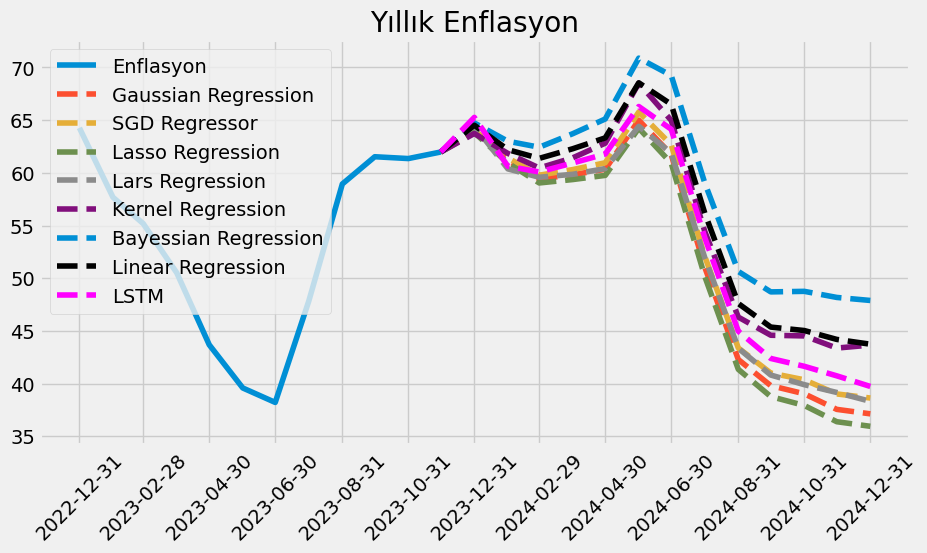

In [358]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:-1],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:-1],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:-1],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:-1],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:-1],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:-1],'--',label="Bayessian Regression")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:-1],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:-1],'--',label="LSTM",color="magenta")
plt.legend(loc=0)
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [359]:

df.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/df.csv')

In [360]:
yıllıktahmin["Maksimum"]=yıllıktahmin.iloc[:,1:10].max(axis=1)
yıllıktahmin["Minimum"]=yıllıktahmin.iloc[:,1:10].min(axis=1)
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:10].mean(axis=1)
yıllıktahmin["Medyan"]=yıllıktahmin.iloc[:,1:11].median(axis=1)
yıllıktahmin.iloc[11:-1].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Maksimum,Minimum,Medyan
2021-12-31,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902,36.080902
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494


In [385]:
sonu2023=str(yıllıktahmin.iloc[24,0])[:5]
tepe=str(yıllıktahmin.iloc[29,0])[:5]
sonu2024=str(yıllıktahmin.iloc[36,0])[:5]
max=str(yıllıktahmin.iloc[-2,-3])[:5]
min=str(yıllıktahmin.iloc[-2,-2])[:5]


In [390]:
min1=str(yıllıktahmin.iloc[36,-2]+1)[:2]
max1=str(yıllıktahmin.iloc[36,-3])[:2]

In [391]:
min1

'36'

In [364]:
df.iloc[-25:,0].shift(12).dropna()

2022-11-30     604.84
2022-12-31     686.95
2023-01-31     763.23
2023-02-28     799.93
2023-03-31     843.64
2023-04-30     904.79
2023-05-31     931.76
2023-06-30     977.90
2023-07-31    1001.03
2023-08-31    1015.65
2023-09-30    1046.89
2023-10-31    1084.00
2023-11-30    1115.26
Freq: M, Name: CPI, dtype: float64

In [375]:
cariay=evds.get_data(["TP.BEK.S01.A.U"],startdate="01-11-2022",enddate="31-12-2023")
cariay=cariay.set_index(pd.date_range(start="2022-11-30",periods=14,freq="1M"))
del cariay["Tarih"]
cariay.columns=["Cari Ay Medyan Tahmin"]
cariay["TÜFE"]=df.iloc[-14:,0].shift(1).dropna()
cariay["Cari Ay Medyan Tahmin"]=1+(cariay["Cari Ay Medyan Tahmin"]/100)
cariay.iloc[-1,1]=1806.50
cariay["Enflasyon"]=cariay["Cari Ay Medyan Tahmin"]*cariay["TÜFE"]
cariay["TÜFE Önceki"]=df.iloc[-25:,0].shift(12).dropna()
cariay.iloc[-1,3]=1128.45
cariay["Enflasyon"]=((cariay["Enflasyon"]/cariay["TÜFE Önceki"])-1)*100
cariay

,Cari Ay Medyan Tahmin,TÜFE,Enflasyon,TÜFE Önceki
2022-11-30,1.0314,1084.00,84.848489,604.84
2022-12-31,1.0269,1115.26,66.716718,686.95
2023-01-31,1.0265,1128.45,51.769968,763.23
2023-02-28,1.0301,1203.48,54.976654,799.93
2023-03-31,1.0288,1241.33,51.377401,843.64
2023-04-30,1.0265,1269.75,44.055347,904.79
2023-05-31,1.0241,1300.04,42.887757,931.76
2023-06-30,1.0281,1300.60,36.736564,977.90
2023-07-31,1.0376,1351.59,40.096679,1001.03
2023-08-31,1.0554,1479.84,53.775724,1015.65


In [379]:
ay1sonra=evds.get_data(["TP.BEK.S01.B.U"],startdate="01-12-2023",enddate="31-12-2023")
ay1sonra["TÜFE"]=1866.34
ay1sonra["TÜFE Yeni"]=(1+(ay1sonra["TP_BEK_S01_B_U"]/100))*ay1sonra["TÜFE"]
ay1sonra["TÜFE Eski"]=df.loc["2023-01-31"]["CPI"]
ay1sonra["Enflasyon"]=((ay1sonra["TÜFE Yeni"]/ay1sonra["TÜFE Eski"])-1)*100
ay1sonra

,Tarih,TP_BEK_S01_B_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2023-12,4.86,1866.34,1957.044124,1203.48,62.615426


In [380]:
ay2sonra=evds.get_data(["TP.BEK.S01.C.U"],startdate="01-12-2023",enddate="31-12-2023")
ay2sonra["TÜFE"]=ay1sonra["TÜFE Yeni"]
ay2sonra["TÜFE Yeni"]=(1+(ay2sonra["TP_BEK_S01_C_U"]/100))*ay2sonra["TÜFE"]
ay2sonra["TÜFE Eski"]=df.loc["2023-02-28"]["CPI"]
ay2sonra["Enflasyon"]=((ay2sonra["TÜFE Yeni"]/ay2sonra["TÜFE Eski"])-1)*100
ay2sonra

,Tarih,TP_BEK_S01_C_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2023-12,3.25,1957.044124,2020.648058,1241.33,62.780893


In [372]:
ay12sonra=evds.get_data(["TP.BEK.S01.E.U"],startdate="01-12-2023",enddate="31-12-2023")
ay12sonra.columns=["Tarih","12 Ay Sonrası"]
ay12sonra

,Tarih,12 Ay Sonrası
0,2023-12,41.23


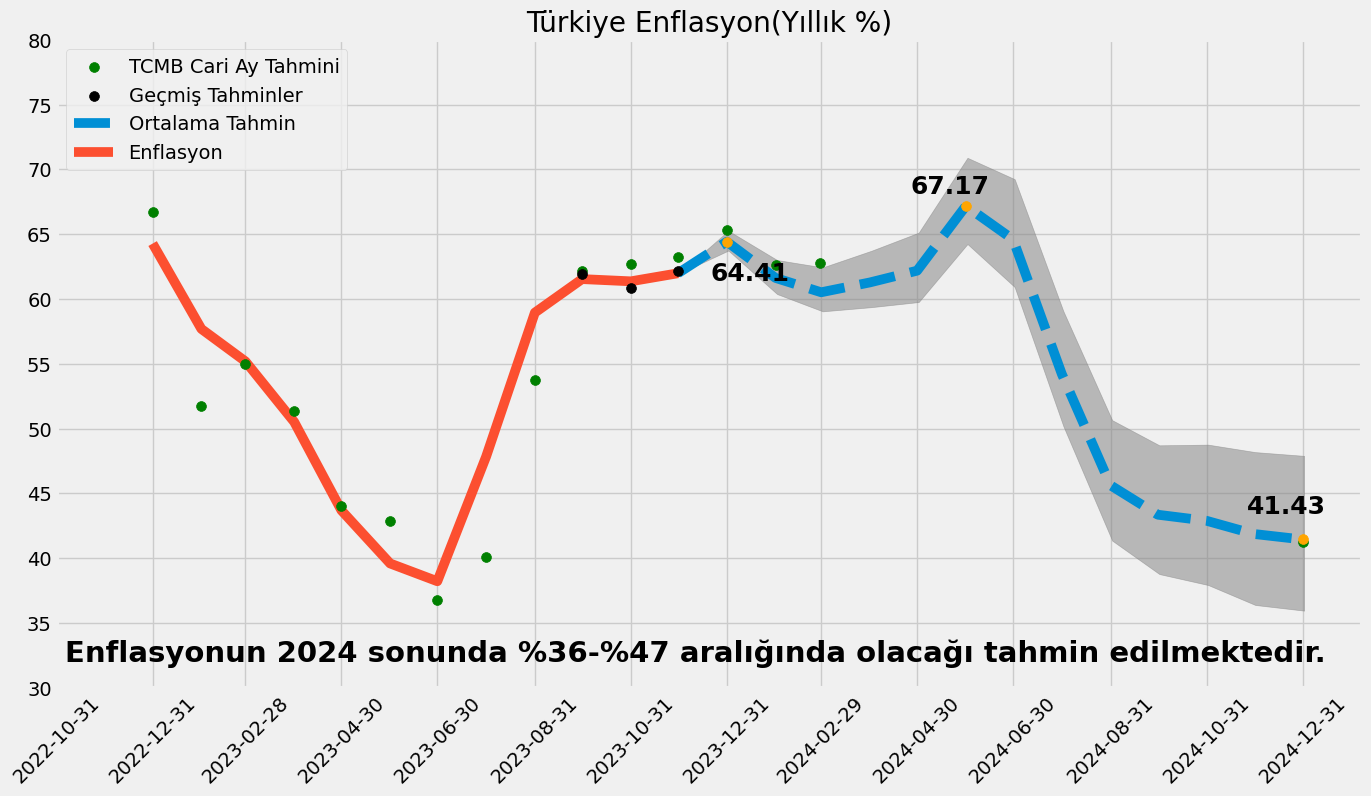

In [392]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-01-31"),y=ay1sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=pd.to_datetime("2024-02-28"),y=ay2sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=cariay[1:].index,y=cariay["Enflasyon"][1:].values,color="green",zorder=3,label='TCMB Cari Ay Tahmini',s=50)
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["12 Ay Sonrası"].values,color="green",zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[21:24],y=[61.94,60.84,62.13],color='black',zorder=3,label='Geçmiş Tahminler',s=50)
plt.scatter(x=yıllıktahmin.index[24],y=yıllıktahmin.iloc[24,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[29],y=yıllıktahmin.iloc[29,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[23:37],'--',label="Ortalama Tahmin",linewidth=7)
plt.plot(yıllıktahmin["Ortalama"].iloc[12:24],label="Enflasyon",linewidth=7)
plt.fill_between(yıllıktahmin.iloc[23:39].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[23:39].shift(1), yıllıktahmin["Minimum"].iloc[23:39].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2025-01')
plt.text(mdates.datestr2num('2024-01'), float(sonu2023)-3, sonu2023, fontsize=18, color='black', horizontalalignment='center',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+1, tepe, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[10:37:2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()


(array([0, 1, 2]),
 [Text(0, 0, '2023-09'), Text(1, 0, '2023-10'), Text(2, 0, '2023-11')])

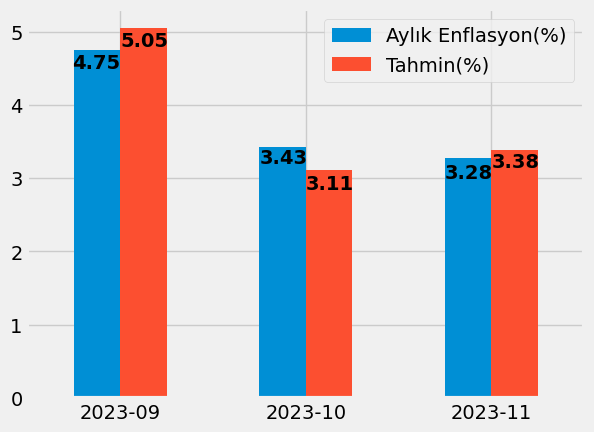

In [ ]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28],"Tahmin(%)":[5.05,3.11,3.38]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=3,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar")
plt.annotate("4.75",xy=(-0.26,4.5),fontweight="bold")
plt.annotate("5.05",xy=(0,4.8),fontweight="bold")
plt.annotate("3.43",xy=(0.75,3.2),fontweight="bold")
plt.annotate("3.11",xy=(1,2.85),fontweight="bold")
plt.annotate("3.28",xy=(1.75,3),fontweight="bold")
plt.annotate("3.38",xy=(2,3.15),fontweight="bold")
plt.legend()
plt.xticks(rotation=0)